
Training\glioma, Number of Images: 0
Training\meningioma, Number of Images: 0
Training\notumor, Number of Images: 0
Training\pituitary, Number of Images: 0
Testing\glioma, Number of Images: 0
Testing\meningioma, Number of Images: 0
Testing\notumor, Number of Images: 0
Testing\pituitary, Number of Images: 0


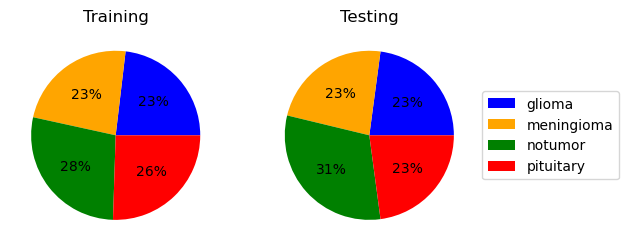

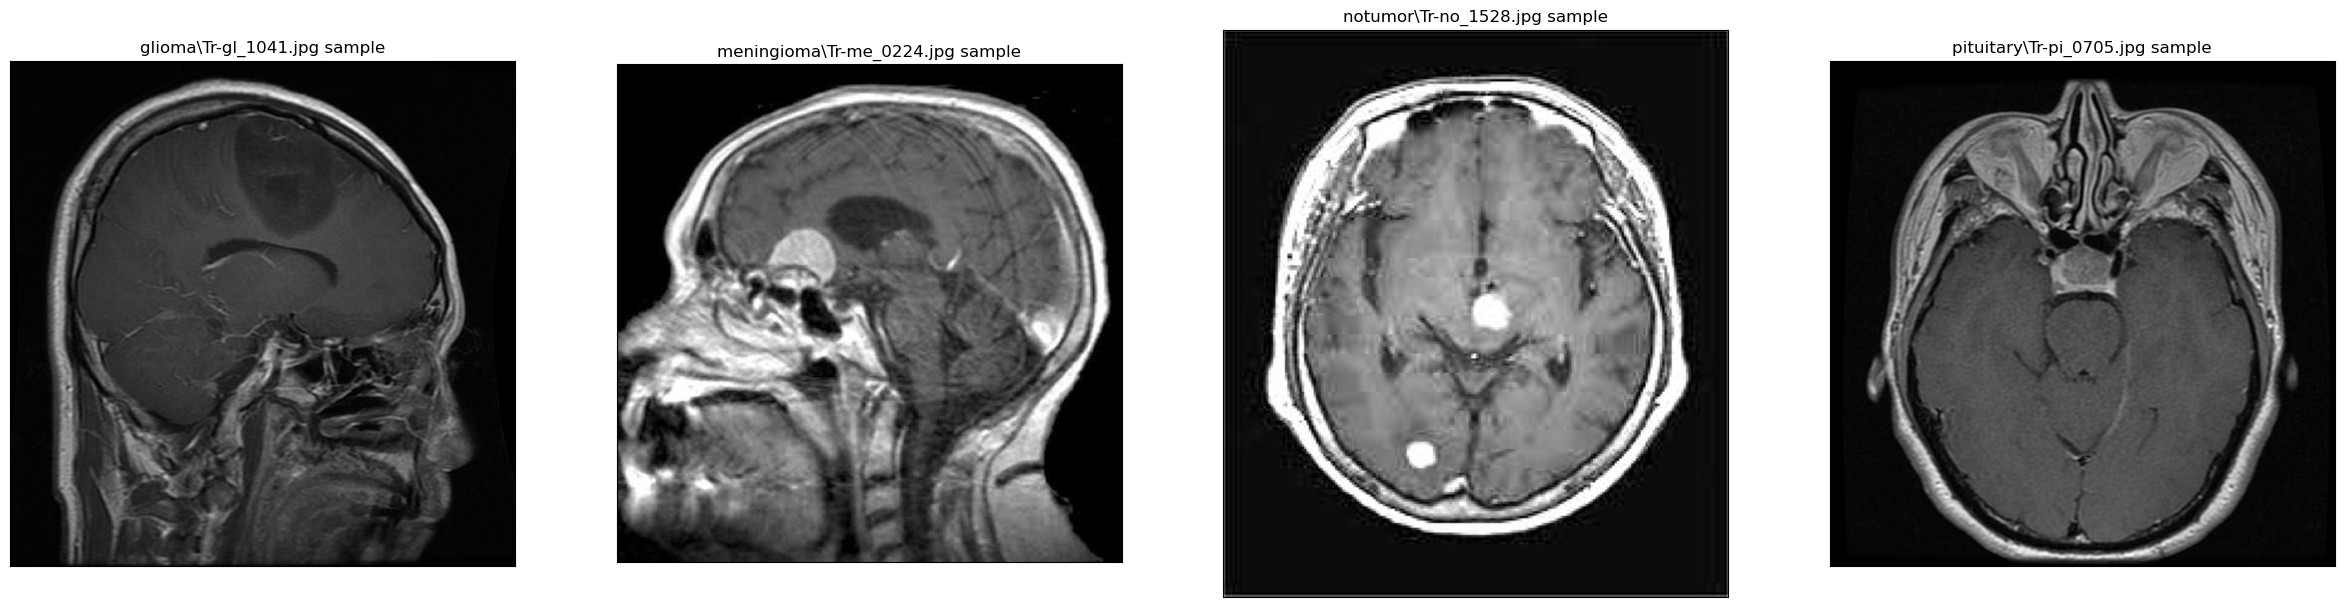

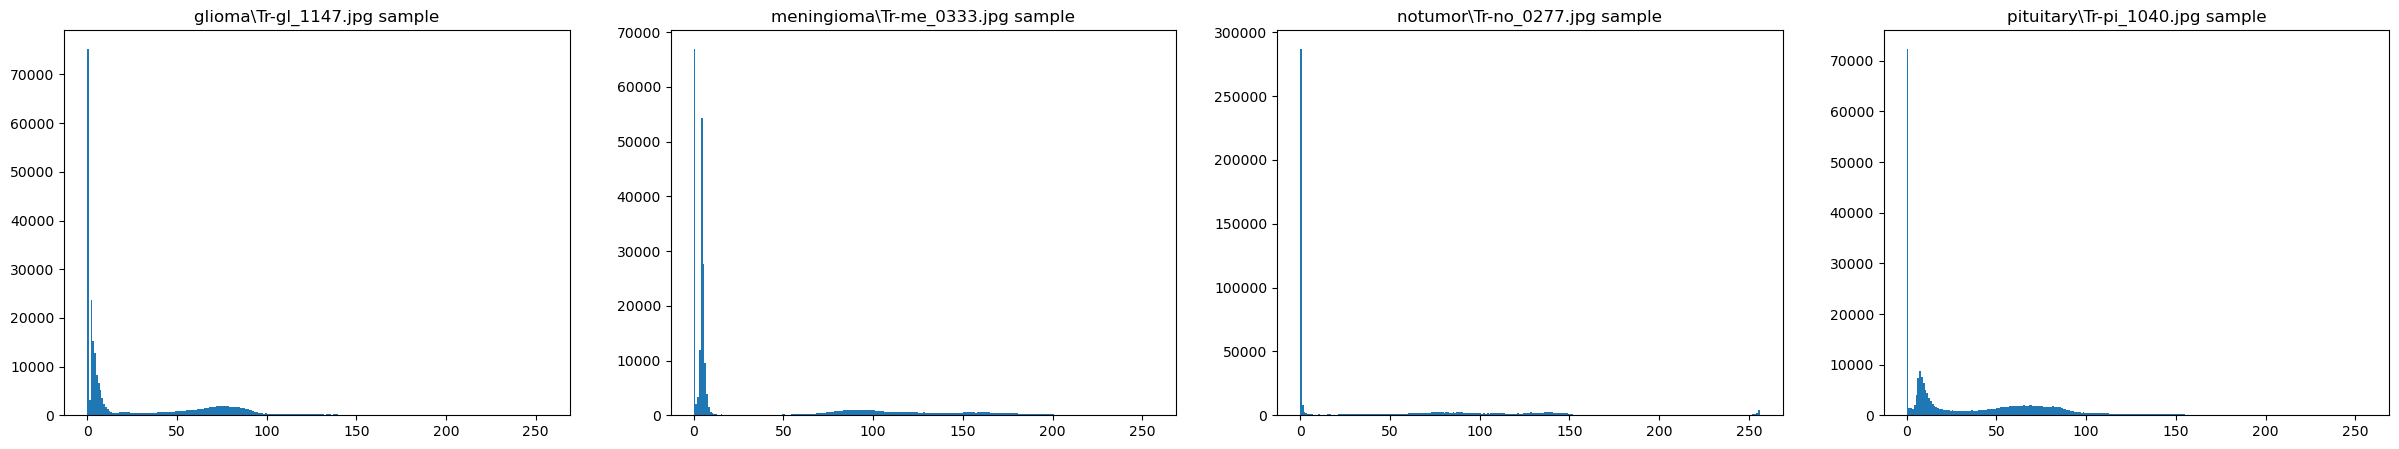

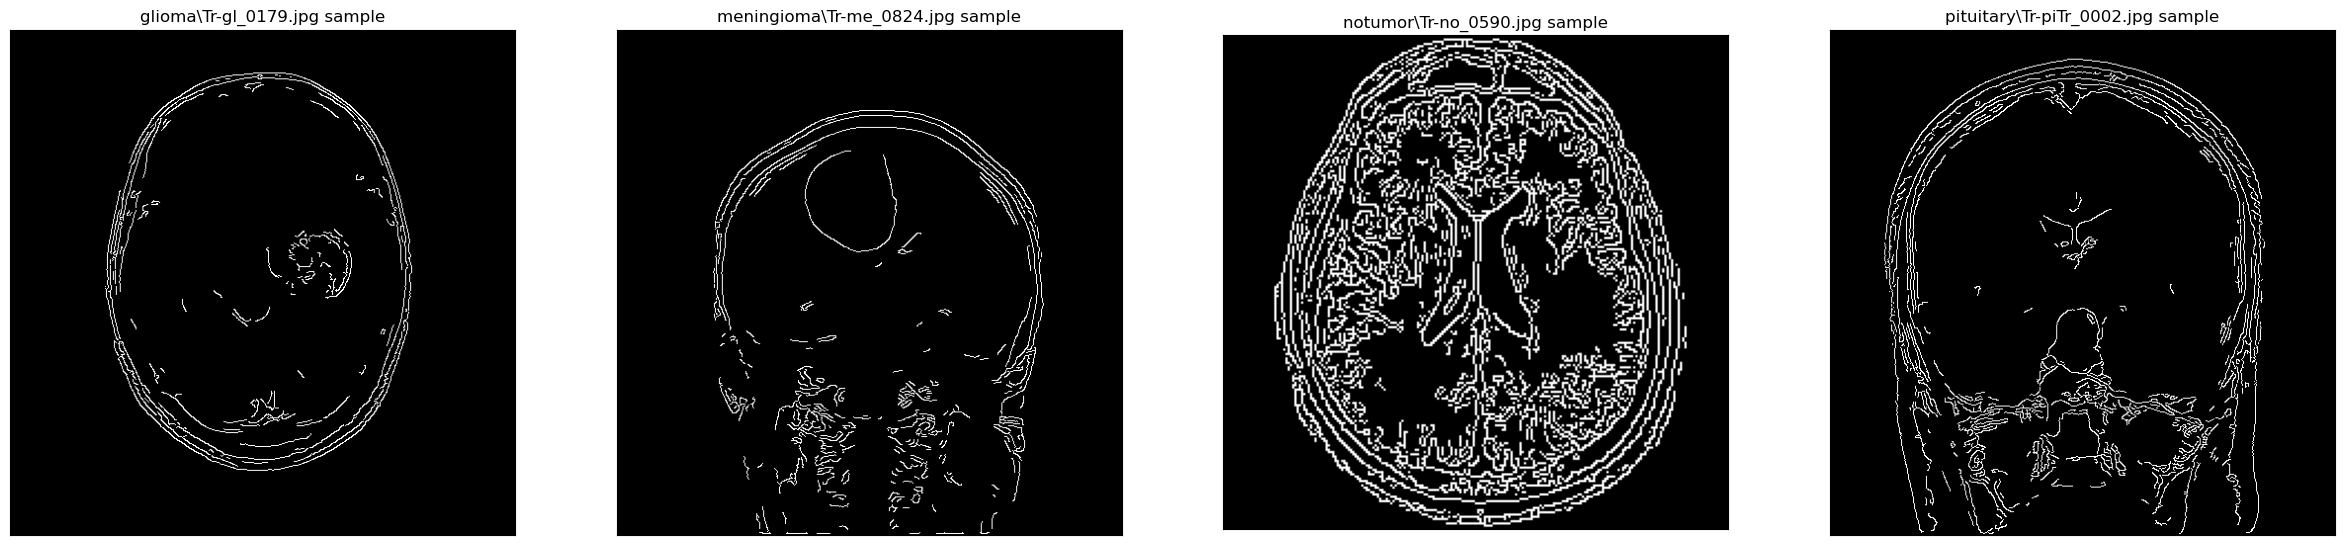

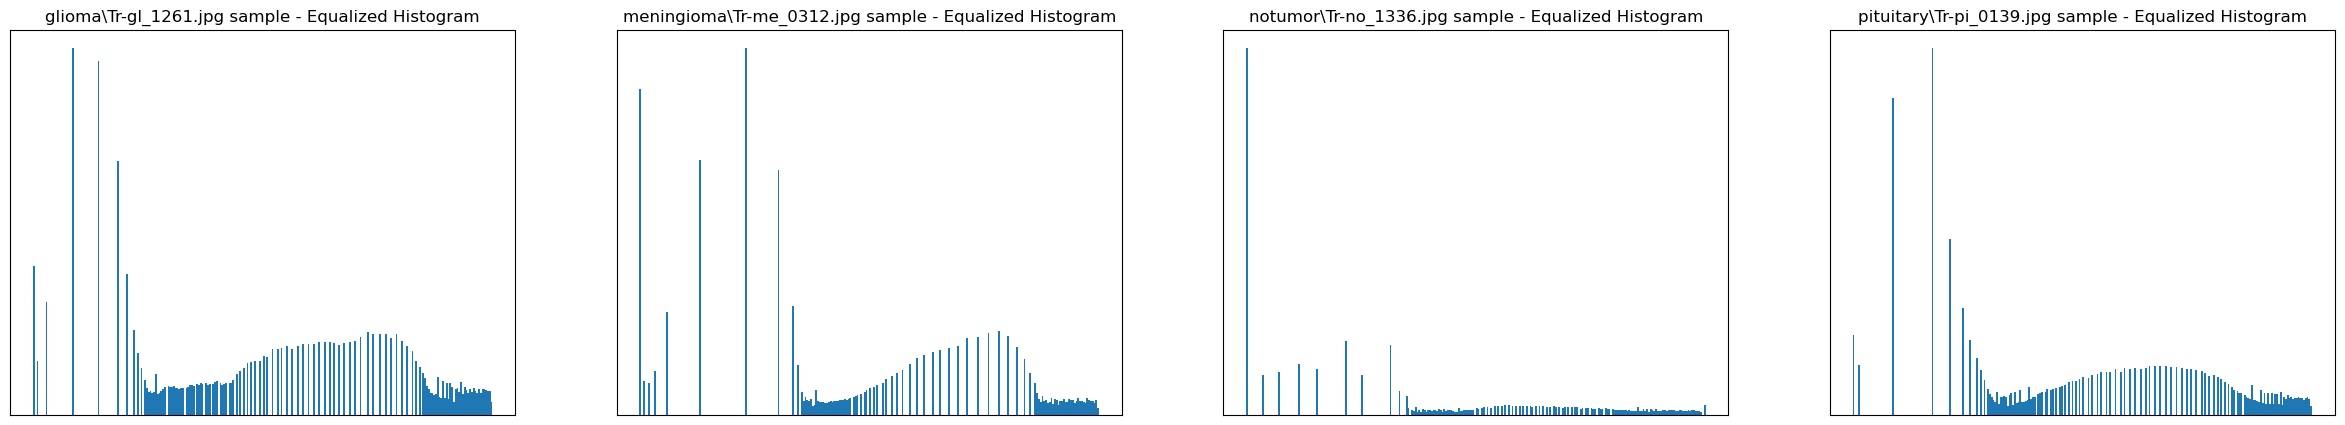

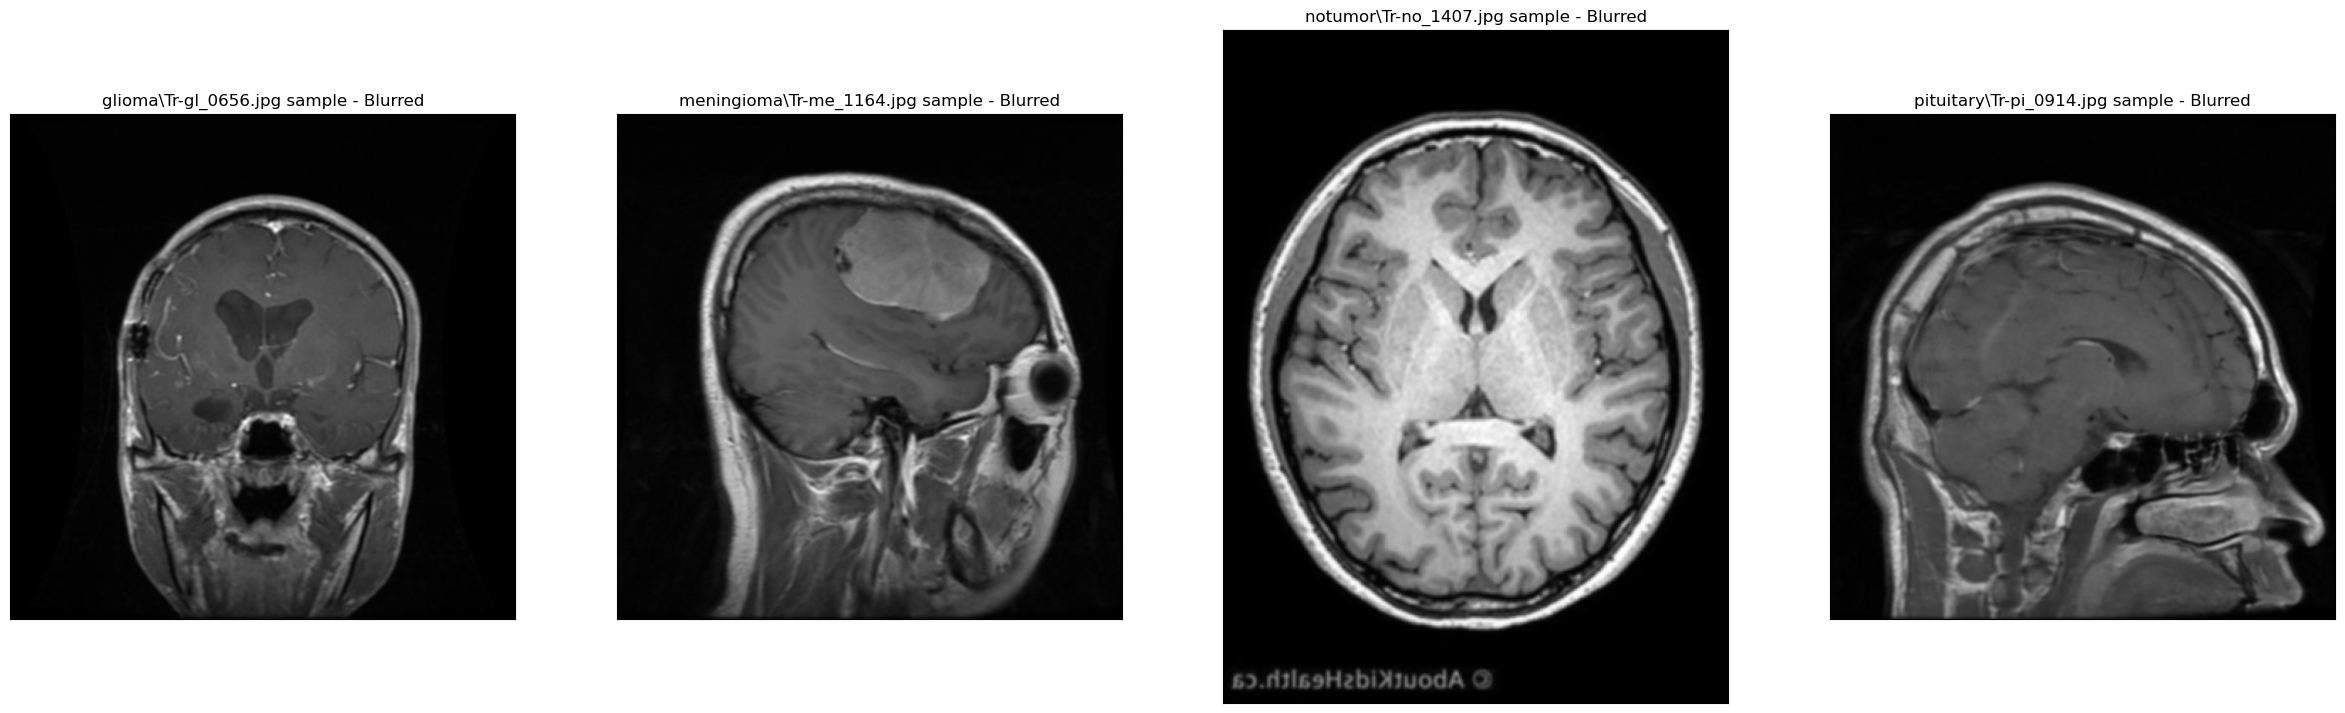

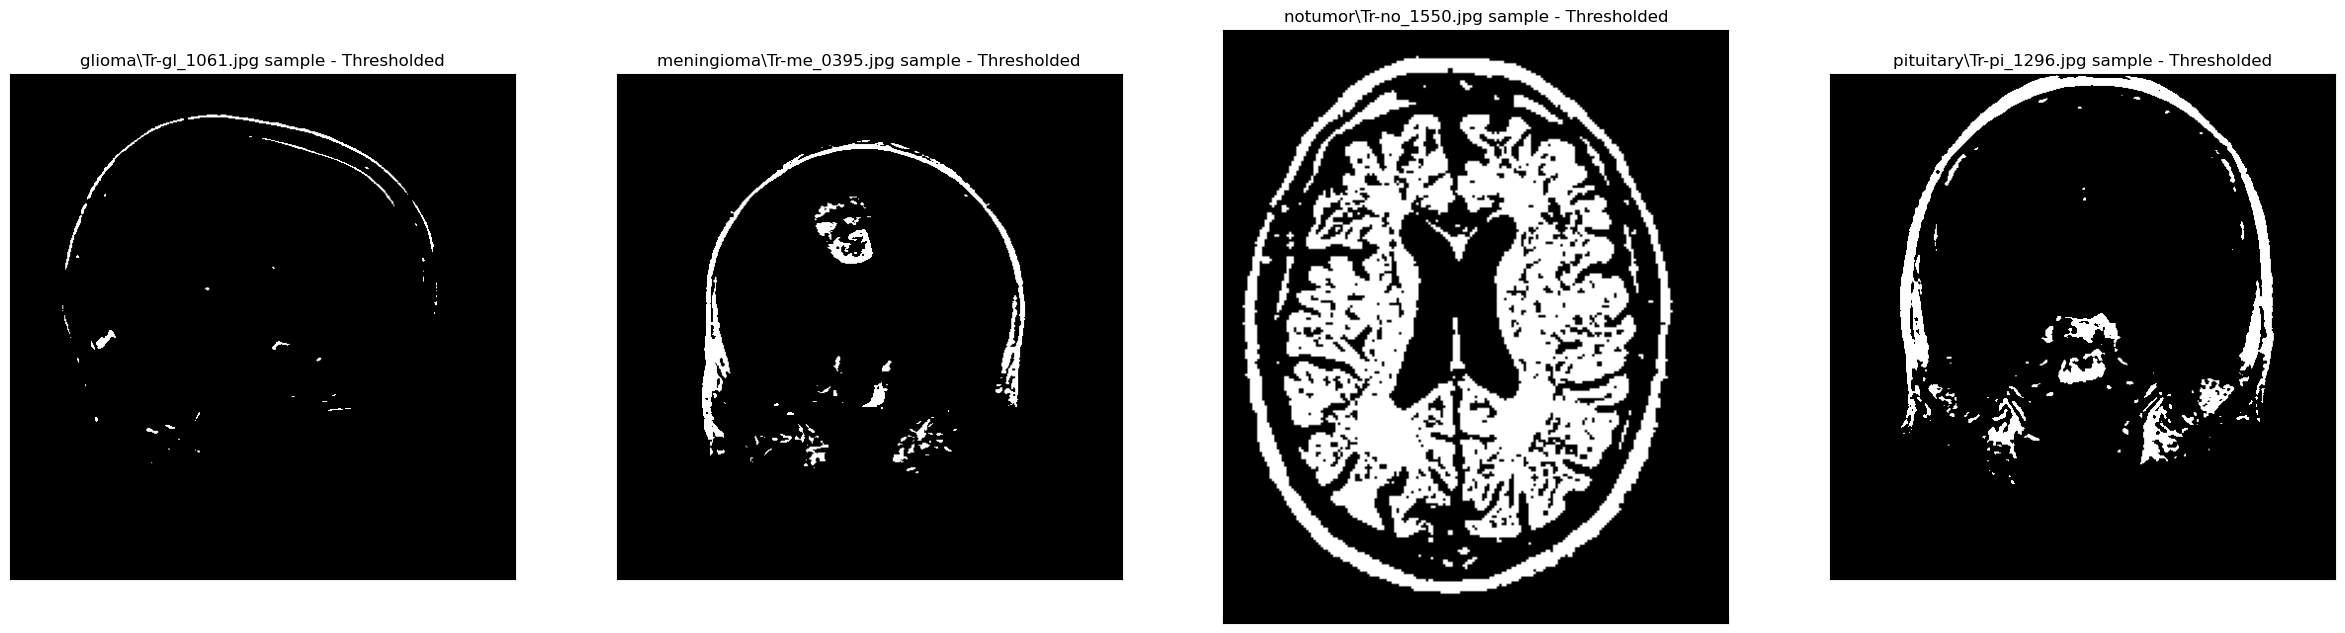

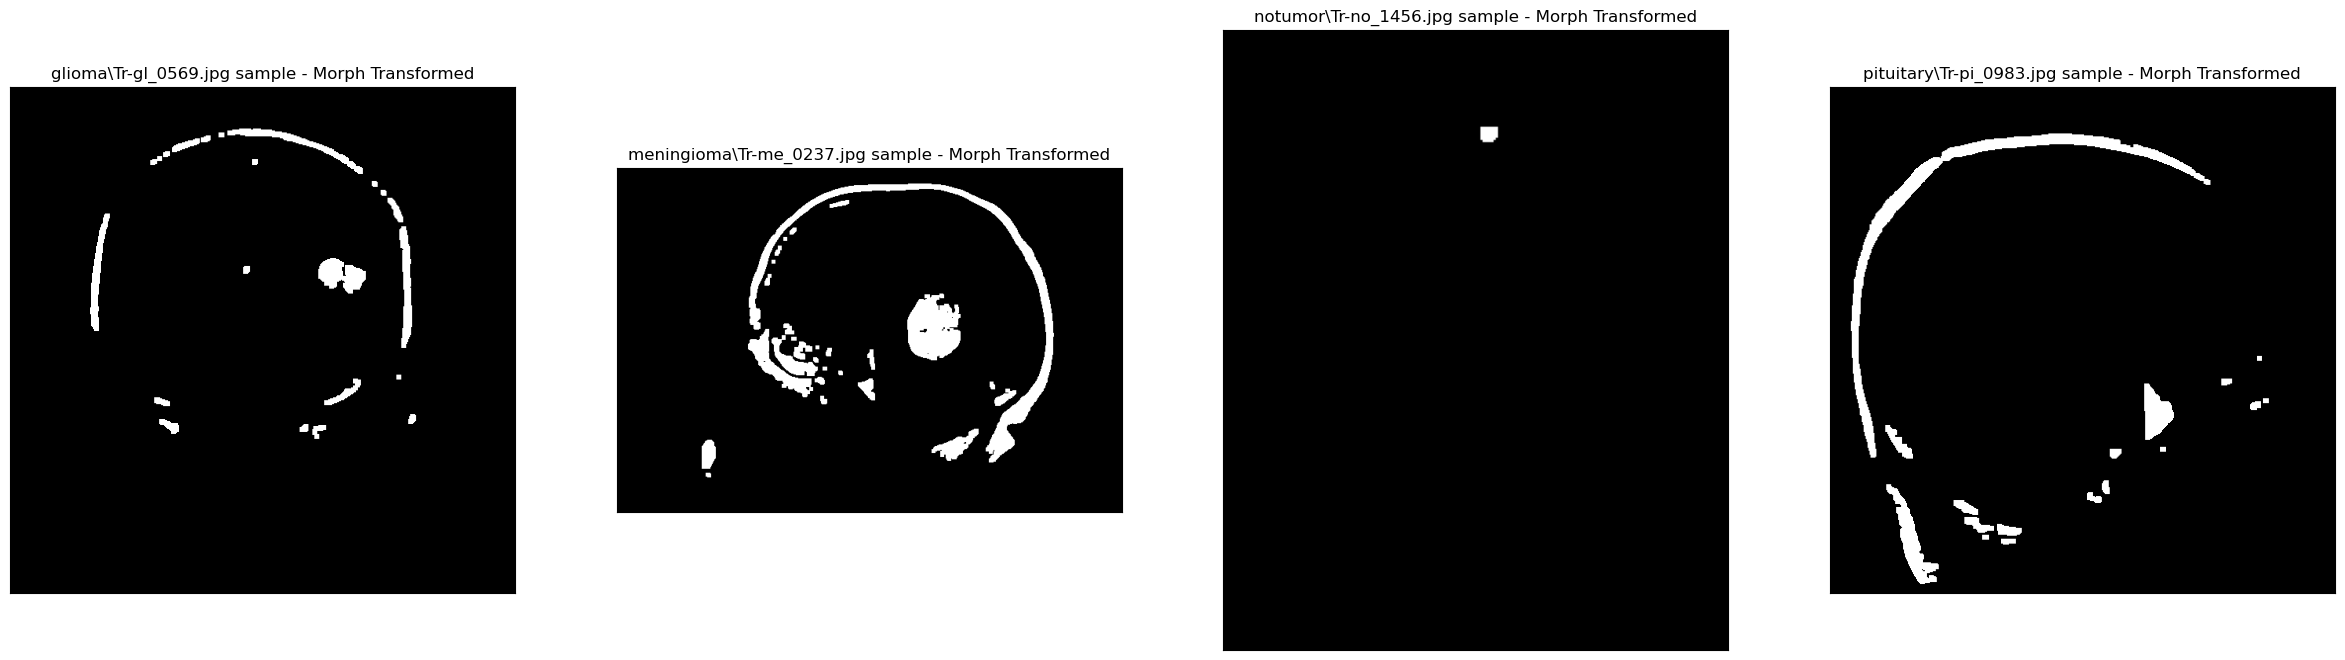



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/25


5/5 [==============================] - ETA: 0s - loss: 1.6404 - categorical_accuracy: 0.4187
Epoch 1: val_categorical_accuracy improved from -inf to 0.25000, saving model to model5_weights.h5
5/5 [==============================] - 22s 4s/step - loss: 1.6404 - categorical_accuracy: 0.4187 - val_loss: 1.3843 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25


C:\Users\dlakhank\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 1.1320 - categorical_accuracy: 0.6438
Epoch 2: val_categorical_accuracy did not improve from 0.25000
5/5 [==============================] - 19s 4s/step - loss: 1.1320 - categorical_accuracy: 0.6438 - val_loss: 1.3913 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/25
5/5 [==============================] - ETA: 0s - loss: 0.9860 - categorical_accuracy: 0.6313
Epoch 3: val_categorical_accuracy did not improve from 0.25000
5/5 [==============================] - 19s 4s/step - loss: 0.9860 - categorical_accuracy: 0.6313 - val_loss: 1.3833 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 4/25
5/5 [==============================] - ETA: 0s - loss: 0.9155 - categorical_accuracy: 0.6875
Epoch 4: val_categorical_accuracy did not improve from 0.25000
5/5 [==============================] - 21s 4s/step - loss: 0.9155 - categorical_accuracy: 0.6875 - val_loss: 1.4008 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 5/25
5/5 [==

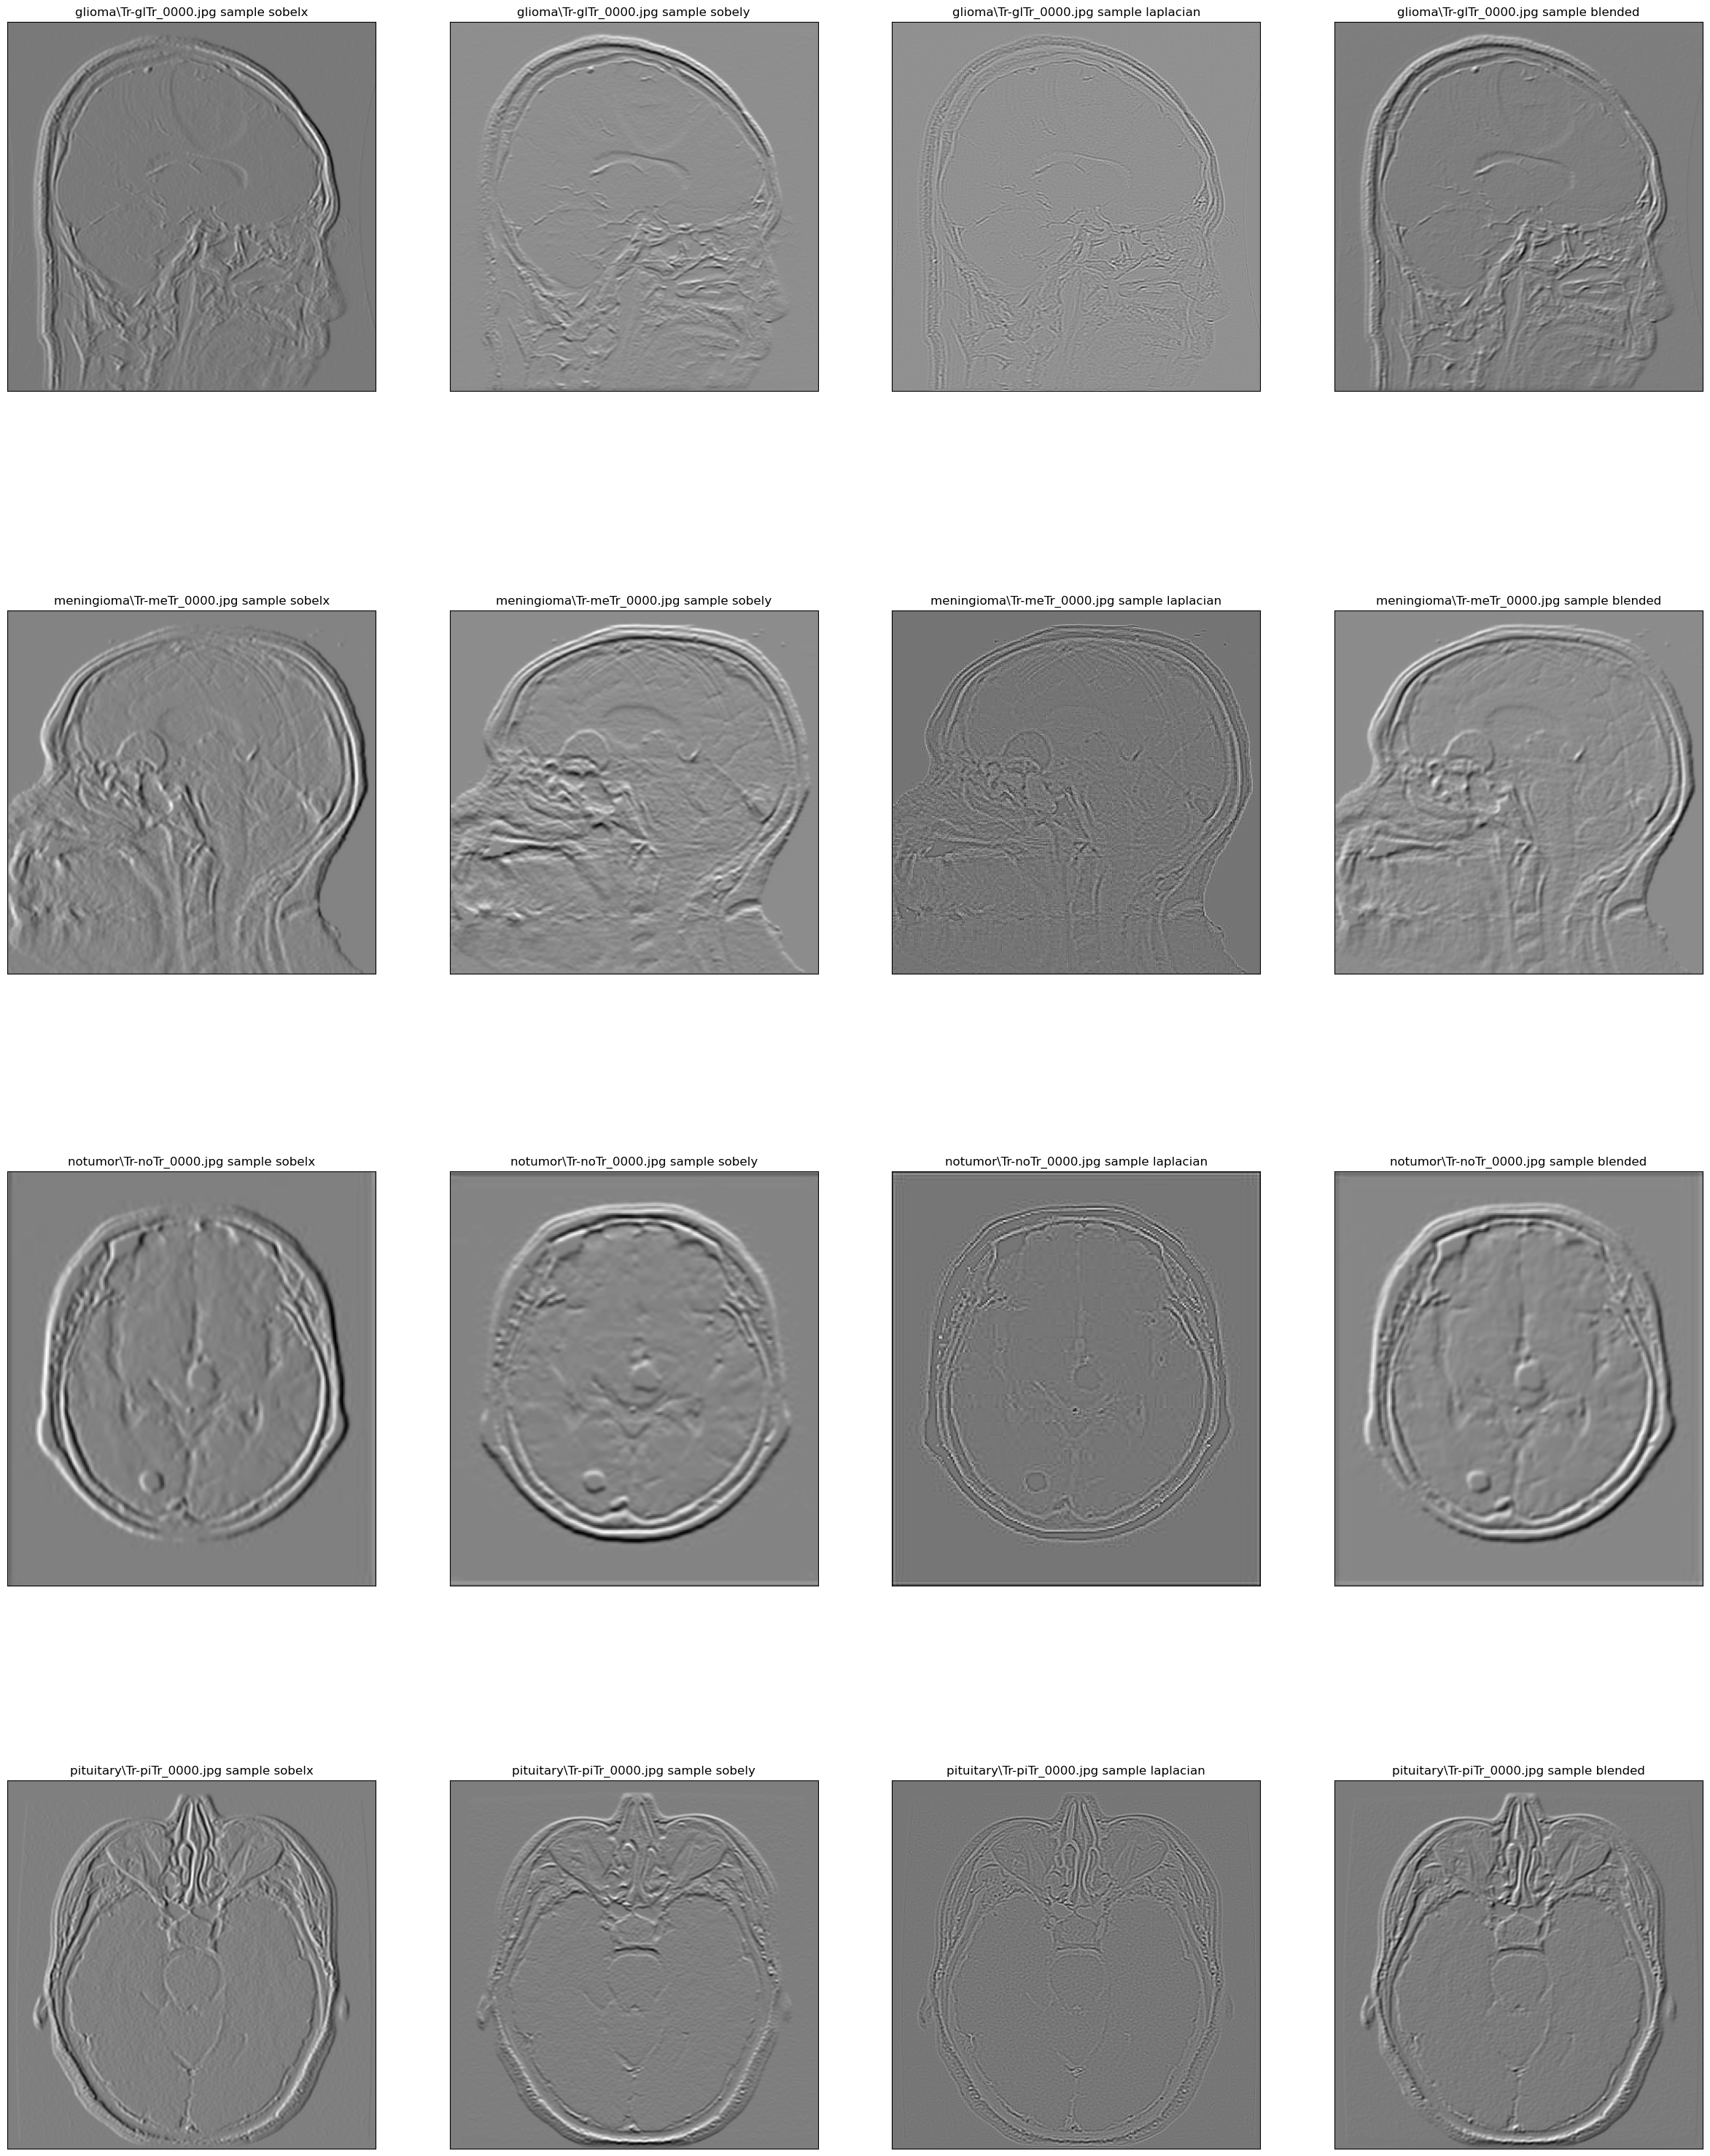

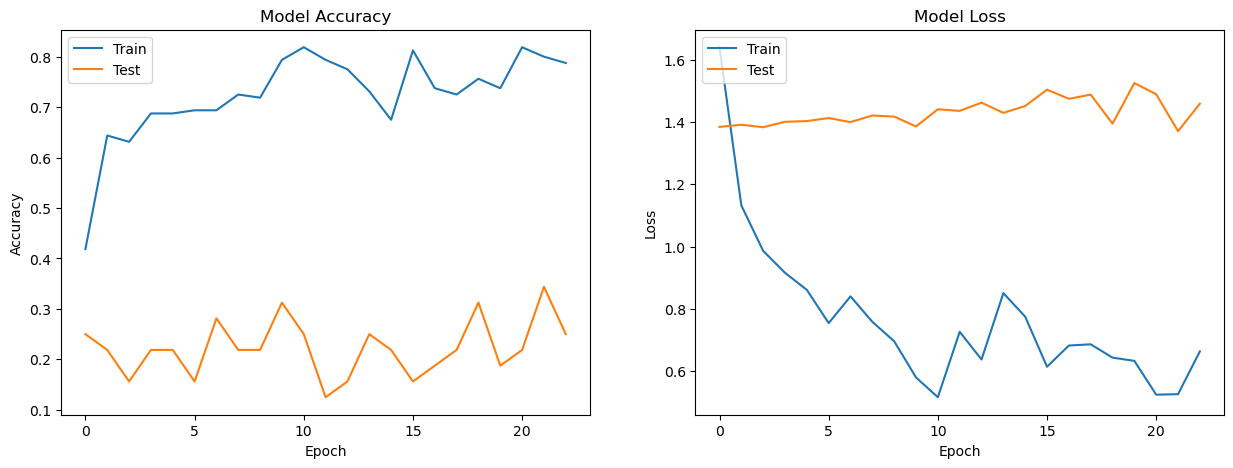

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
local_input_dir = r'Brain_tumor_MRI'
target_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
subsets = ['Training', 'Testing']

for subset in subsets:
    for target_folder in target_folders:
        folder_path = os.path.join(local_input_dir, 'Brain_tumor_MRI', subset, target_folder)
        last_num_pics = sum([len(filenames) for _, _, filenames in os.walk(folder_path) if not any('__MACOSX' in path for path in filenames)])
        print(f"{subset}\\{target_folder}, Number of Images: {last_num_pics}")

In [ ]:
def load_data(base_path):
    data = {}
    for root, _, filenames in os.walk(base_path):
        dirname = os.path.relpath(root, base_path).split(os.path.sep)[-1]
        for filename in filenames:
            if dirname not in data:
                data[dirname] = []
            relative_path = os.path.relpath(os.path.join(root, filename), base_path)
            data[dirname].append(relative_path)
    return data

In [ ]:
training_data = load_data(r'Brain_tumor_MRI\Training')
testing_data = load_data(r'Brain_tumor_MRI\Testing')

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

training_ds = pd.Series([len(training_data[k]) for k in training_data], index=training_data.keys())
training_ds.plot(ax=axes[0], kind='pie', autopct='%1.0f%%', colors=['blue', 'orange', 'green', 'red'], labels=None)
axes[0].set_title('Training')

testing_ds = pd.Series([len(testing_data[k]) for k in testing_data], index=testing_data.keys())
testing_ds.plot(ax=axes[1], kind='pie', autopct='%1.0f%%', colors=['blue', 'orange', 'green', 'red'], labels=None)
axes[1].legend(["glioma", "meningioma", "notumor", "pituitary"], loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Testing')

plt.show()

In [ ]:
data = {}

base_path = r'Brain_tumor_MRI\Training'

for root, dirs, files in os.walk(base_path):
    for dir_name in dirs:
        class_path = os.path.join(root, dir_name)
        file_paths = [os.path.join(class_path, file) for file in os.listdir(class_path)]
        data[dir_name] = file_paths

In [ ]:
plt.figure(figsize=(30, 20))

samples = []
for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    samples.append(s)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[-1], cmap='gray')
    plt.title(relative_path + ' sample')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(30, 5))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')

    plt.subplot(1, 4, i + 1)
    plt.hist(s.ravel(), 256, [0, 256])
    plt.title(relative_path + ' sample')

plt.show()

In [ ]:
plt.figure(figsize=(30, 20))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    s = cv2.Canny(s, threshold1=140, threshold2=210)
    
    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(s, cmap='gray')
    plt.title(relative_path + ' sample')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(30, 5))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')

    plt.subplot(1, len(data), i + 1)
    equ = cv2.equalizeHist(s)
    plt.hist(equ.ravel(), 256, [0, 256])
    plt.title(relative_path + ' sample - Equalized Histogram')

    plt.xticks([])
    plt.yticks([])

plt.show()


In [ ]:
plt.figure(figsize=(30, 20))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(s, (5, 5), 0)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')

    plt.subplot(1, 4, i + 1)
    plt.imshow(blurred, cmap='gray')
    plt.title(relative_path + ' sample - Blurred')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(30, 20))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    
    _, thresholded = cv2.threshold(s, 128, 255, cv2.THRESH_BINARY)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')

    plt.subplot(1, 4, i + 1)
    plt.imshow(thresholded, cmap='gray')
    plt.title(relative_path + ' sample - Thresholded')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(30, 20))

for i, k in enumerate(data.keys()):
    file_path = random.choice(data[k])
    s = cv2.imread(file_path)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    
    _, thresholded = cv2.threshold(s, 128, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    morph_transformed = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)

    relative_path = os.path.relpath(file_path, r'Brain_tumor_MRI\Training')

    plt.subplot(1, 4, i + 1)
    plt.imshow(morph_transformed, cmap='gray')
    plt.title(relative_path + ' sample - Morph Transformed')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
plt.figure(figsize=(30, 40))

j = 0

for i, s in enumerate(samples):
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=5)
    laplacian = cv2.Laplacian(s, cv2.CV_64F)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.5, src2=sobely, beta=0.5,gamma=0)
    
    
    plt.subplot(4, 4, i + j + 1)
    plt.imshow(sobelx, cmap='gray')
    plt.title(os.path.relpath(list(data.values())[i][0], r'Brain_tumor_MRI\Training') + ' sample sobelx')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 2)
    plt.imshow(sobely, cmap='gray')
    plt.title(os.path.relpath(list(data.values())[i][0], r'Brain_tumor_MRI\Training') + ' sample sobely')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title(os.path.relpath(list(data.values())[i][0],r'Brain_tumor_MRI\Training') + ' sample laplacian')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 4, i + j + 4)
    plt.imshow(blended, cmap='gray')
    plt.title(os.path.relpath(list(data.values())[i][0],r'Brain_tumor_MRI\Training')+ ' sample blended')
    plt.xticks([])
    plt.yticks([])
    
    
    j += 3

In [ ]:
model5 = Sequential()

# Convolutional layer 1
model5.add(Conv2D(64,(7,7), input_shape=(200, 200, 1), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model5.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Full connect layers

model5.add(Dense(units= 1024, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=512, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=4, activation='softmax'))
model5.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

train = generator_train.flow_from_directory(r'Brain_tumor_MRI\Training', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory(r'Brain_tumor_MRI\Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

In [ ]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)
batch_size = 32 

In [ ]:
history5 = model5.fit(
    train,
    steps_per_epoch=len(train) // batch_size,
    epochs=25,
    validation_data=test,
    validation_steps=len(test) // batch_size,
    callbacks=[model5_es, model5_rlr, model5_mcp]
)

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history5.history['categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()